- Introduction to the ABSESpy package
- Context and motivation (Explain Hotelling's Law)
- Model setup
- Model level methods
- Agent level methods
- Visualizations and model metrics

# Introducing the ABSESpy package

<div class="admonition note">
    <p class="admonition-title">In progress</p>
    <p>This document is a work in progress if you see any errors, or exclusions or have any problems, please <a href="https://github.com/absespy/ABSESpy/issues">get in touch with us</a>.</p>
</div>

The following introduces the ABSESpy python package for individual-based simulations in the context ofsocial-ecological systems. The package is designed to loose integrate societal elements as well as environmental ones. In order to follow the tutorial, please make sure that you have it installed. 

```
%pip install --upgrade abses"
```

This introduction presents the basic structure of the package and its main components by means of building a simple model, illustrating each step of the process. The model chosen is an adaptation of the Hotelling's Law model. The counterpart written in Netlogo can be found [here](https://ccl.northwestern.edu/netlogo/models/Hotelling'sLaw). The Hotelling's Law, also referred to as the Law of minimum differentiation states that profit maximizing firms competing in a market with two substitute goods will settle close to each other and also lower their prices. Although the notion of distance related to space both in the original paper by Hotelling (1929) and its netlogo implementation, its definition can be expanded to other dimensions of interest.

In [1]:
import numpy as np

from abses import Actor, MainModel
from abses.datacollection import DataCollector

# Instantiate a random number generator
rng = np.random.default_rng()


# Calculate euclidean distance between two points
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

In [2]:
class Shop(Actor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.price = 10
        self.area_count = 0
        self.unique_id = rng.integers(
            1e6, 1e7
        )  # FIXME: no two agents should have the same id
        # cached results
        self.next_position = None
        self.next_price = None

    def __repr__(self):
        return f"Shop {self.id}"

    def step(self):
        self.adjust_price()
        self.adjust_position()

    def advance(self):
        self.affect_price()
        self.affect_position()

    def adjust_price(self):
        # Save initial price
        initial_price = self.price

        # Build a list of all possible prices
        _possible_prices = [self.price - 1, self.price, self.price + 1]

        # Pair each possible price change to its potential revenue
        _potential_revenues = {}
        for price in _possible_prices:
            self.price = price
            _potential_revenues[price] = (
                self.model.recalculate_areas()[self] * price
            )
        # Check if all potential revenues are 0
        # if so, decrease price by 1
        if all(value == 0 for value in _potential_revenues.values()):
            self.next_price = self.price - 1
        # Otherwise, choose the price with the highest potential revenue
        else:
            self.next_price = max(
                _potential_revenues, key=_potential_revenues.get
            )

        # Reset price to initial price
        self.price = initial_price

    def adjust_position(self):
        # Save initial position
        initial_pos = self.pos

        # Get all possible candidates for the next position
        _possible_moves = self.model.nature.major_layer.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        # Pair each possible move to their potential areas
        _potential_areas = {}
        for move in _possible_moves:
            self.move_to(move)
            _potential_areas[move] = self.model.recalculate_areas()[self]

        # Single out the store with the highest potential area and savi it
        _choice = max(_potential_areas, key=_potential_areas.get)
        self.next_position = _choice

        # Pull back to initial position if the potential area
        self.move_to(initial_pos)

    def affect_price(self):
        self.price = self.next_price

    def affect_position(self):
        self.move_to(self.next_position)

In [3]:
class Hotelling(MainModel):
    def __init__(self, N, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_agents = N

    def setup(self):
        # Initialize a grid of shape (12, 12)
        self.nature.create_module(how="from_resolution", shape=(12, 12))

        # Create a list of agents
        self.agents.new(Shop, self.num_agents)

        # Placed agents on the grid randomly
        positions = rng.integers(12, size=(self.num_agents, 2), dtype=np.int8)

        for i, agent in enumerate(self.actors):
            agent.put_on_layer(
                layer=self.nature.major_layer, pos=tuple(positions[i])
            )

        # Initialize a DataCollector object
        self.datacollector = DataCollector(
            self,
            agent_reporters={"Price": "price", "Area": "area_count"},
            model_reporters={
                "avg_price": lambda _model: np.mean(
                    [actor.price for actor in _model.actors]
                )
            },
        )

    def step(self):
        # recalculate areas and assign them to each agent
        areas = self.recalculate_areas()

        for shop in self.actors:
            shop.area_count = areas[shop]

        # trigger all agents to step
        self.actors.trigger("step")

        # let price and positional changes take effect
        self.actors.trigger("advance")

        # collect data
        self.datacollector.collect()

    def recalculate_areas(self):
        areas = {}

        for shop in self.actors:
            areas[shop] = 0

        _width = self.nature.major_layer.width  # columns
        _height = self.nature.major_layer.height  # rows

        for i in range(_height):
            for j in range(_width):
                dist = {}
                for shop in self.actors:
                    _dist = (
                        euclidean_distance(i, j, shop.pos[0], shop.pos[1])
                        + shop.price
                    )
                    dist[shop] = _dist
                _choice = min(dist, key=dist.get)
                areas[_choice] += 1

        return areas

In [16]:
INITIALIZE = True

parameters = {
    "time": {
        "end": 100,
    }
}

if INITIALIZE:
    model = Hotelling(N=4, parameters=parameters)

model.run_model()

tick[100] 2023-11-26 15:04:02

<Axes: >

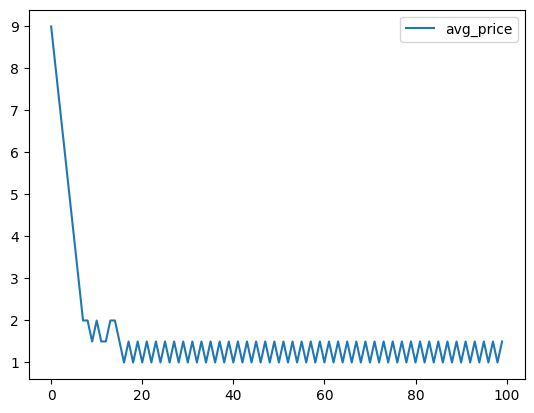

In [14]:
model.datacollector.get_model_vars_dataframe().plot()

<Axes: >

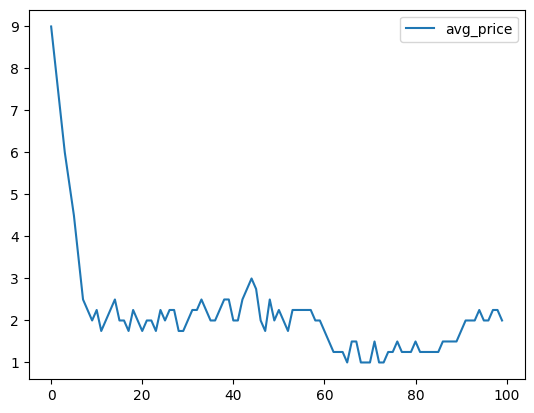

In [17]:
model.datacollector.get_model_vars_dataframe().plot()